## Survival Analysis - Primary Biliary Cirrhosis

By Ronnie Nop

### Introduction
**Primary biliary cirrhosis (PBC)** is a chronic liver disease caused by the buildup up bile, amino acids, and other substances in the bile ducts resulting in the progressive destruction of the liver. There are currently no known treatments to cure PBC, however, there are many ways to slow down its progression through treatment, surgery, and supportive care. **Survival analysis** offers a way to help clinicians diagnose severely diseased patients which can help decide the best appropriate treatments and plan of action to improve their survivability.  

### What is Survival Analysis?
Survival analysis is used to analyze data in which **time to the event** is the focus of interest where the response variable is either event time or survival time. The original purpose has its morbid roots in the medical field where clinicians were interested in predicting the survival probabilities of patients with a particular disease based on their individual features/covariates. Domains outside the clinical field have applied survival analysis to problems such as customer churn prediction, bank loan survival, credit risk, etc. 

### Survival Function $S(t)$
A primary objective of survival analysis is to estimate the **survival curve** (or survival function) that quantifies the probability of survival as a function of time. The survival function is defined as the probability of an observation surviving up until time t where T is a random variable of survival time.

$$
S(t)=P(T>t)
$$

### The Dataset
* id: patient identification number
* time: how long patient lived before they died or censored in years
* status: 0=alive, 1=liver transplant, 2=dead
* trt: 1=D-penicillamine, 2=placebo
* age: age of patient in days
* sex: f=female, m=male
* ascites: presence of ascites (0=no, 1=yes)
* hepato: presence of hepatomegaly (0=no, 1=yes)
* spiders: presence of spiders (0=no, 1=yes)
* edema: 0=no edema, 0.5=edema present without diuretics or edema resolved by diuretics, 1=edema with diuretic therapy
* bili: serum bilirubin in mg/dl
* chol: serum cholesterol in mg/dl
* albumin: albumin in gm/dl
* copper: urine copper in ug/day
* alk.phos: alkaline phosphatase in U/L
* ast: AST test evaluating liver enzyme in blood
* trg: triglicerides in mg/dl
* platelet: platelets per cubic ml/1000
* protime: prothrombin time in seconds
* stage: histologic stage of disease

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
np.random.seed(0)

In [3]:
df = pd.read_csv('data/pbc.csv')

In [4]:
df.sample(5)

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
360,361,617,1,NaN,40.999316,f,NaN,NaN,NaN,0.0,5.5,NaN,2.31,NaN,NaN,NaN,NaN,517.0,10.4,4.0
170,171,2574,0,1.0,52.668036,f,0.0,0.0,0.0,0.0,0.5,NaN,4.52,31.0,784.0,74.40,NaN,361.0,10.1,3.0
224,225,2022,0,1.0,38.770705,f,0.0,0.0,0.0,0.0,0.7,274.0,3.66,108.0,1065.0,88.35,135.0,251.0,10.1,2.0
358,359,2534,0,NaN,46.001369,f,NaN,NaN,NaN,0.0,0.8,NaN,2.89,NaN,NaN,NaN,NaN,419.0,NaN,1.0
309,310,939,0,1.0,62.332649,f,0.0,0.0,0.0,0.0,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0


### Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        418 non-null    int64  
 1   time      418 non-null    int64  
 2   status    418 non-null    int64  
 3   trt       312 non-null    float64
 4   age       418 non-null    float64
 5   sex       418 non-null    object 
 6   ascites   312 non-null    float64
 7   hepato    312 non-null    float64
 8   spiders   312 non-null    float64
 9   edema     418 non-null    float64
 10  bili      418 non-null    float64
 11  chol      284 non-null    float64
 12  albumin   418 non-null    float64
 13  copper    310 non-null    float64
 14  alk.phos  312 non-null    float64
 15  ast       312 non-null    float64
 16  trig      282 non-null    float64
 17  platelet  407 non-null    float64
 18  protime   416 non-null    float64
 19  stage     412 non-null    float64
dtypes: float64(16), int64(3), object

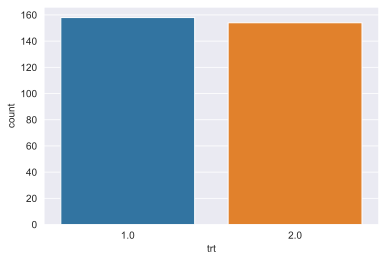

In [6]:
sns.countplot(df['trt'])
plt.show()

In [7]:
df['trt'].value_counts()

1.0    158
2.0    154
Name: trt, dtype: int64

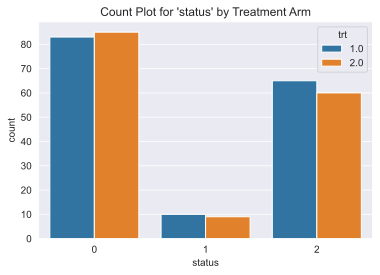

0    232
2    161
1     25
Name: status, dtype: int64


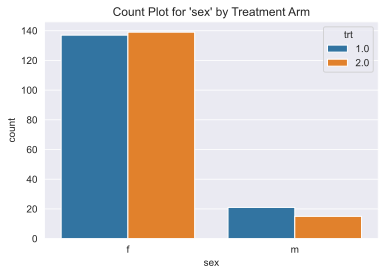

f    374
m     44
Name: sex, dtype: int64


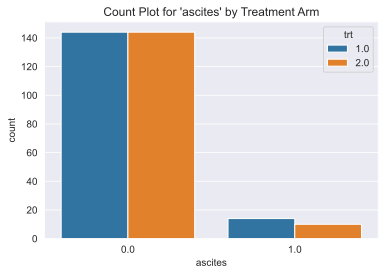

0.0    288
1.0     24
Name: ascites, dtype: int64


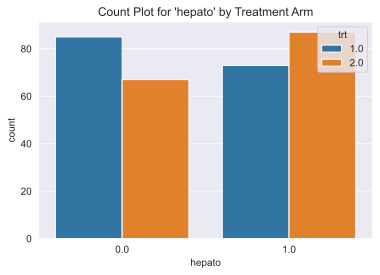

1.0    160
0.0    152
Name: hepato, dtype: int64


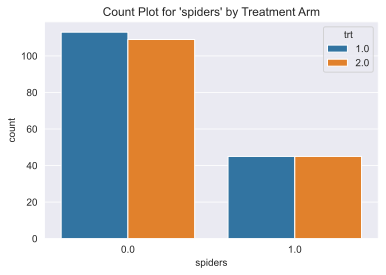

0.0    222
1.0     90
Name: spiders, dtype: int64


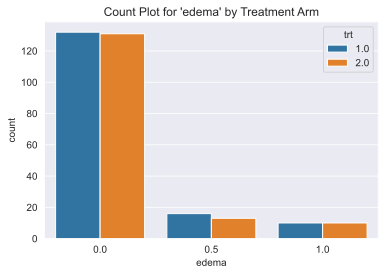

0.0    354
0.5     44
1.0     20
Name: edema, dtype: int64


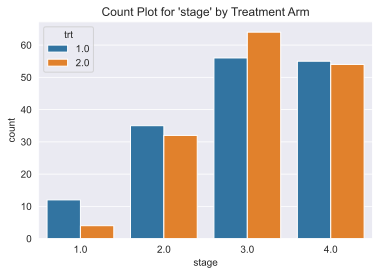

3.0    155
4.0    144
2.0     92
1.0     21
Name: stage, dtype: int64


In [8]:
cat_cols = ['status', 'sex', 'ascites', 'hepato', 'spiders', 'edema','stage']
for col in cat_cols:
    sns.countplot(df[col], hue=df['trt'])
    plt.title(f"Count Plot for '{col}' by Treatment Arm")
    plt.show()
    print(df[col].value_counts())

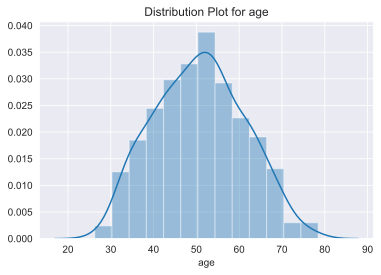

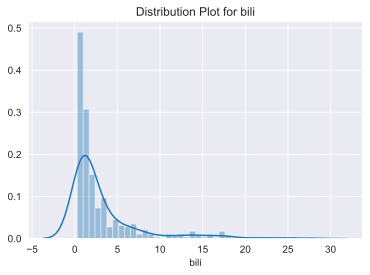

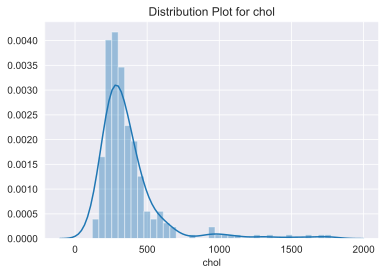

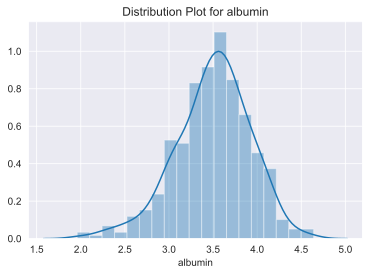

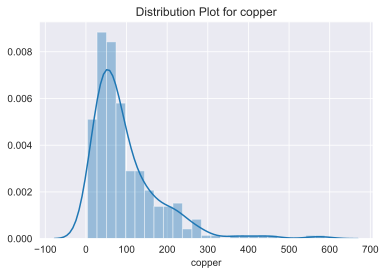

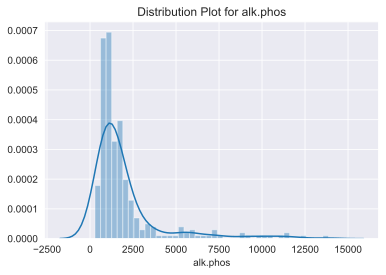

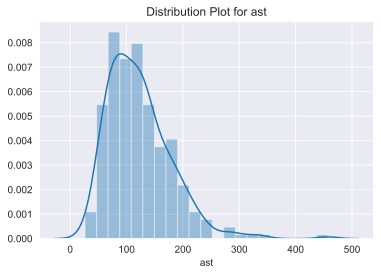

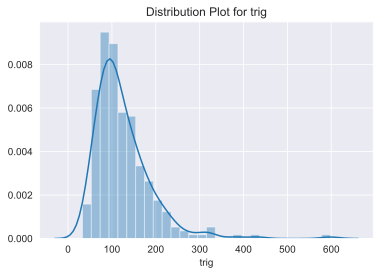

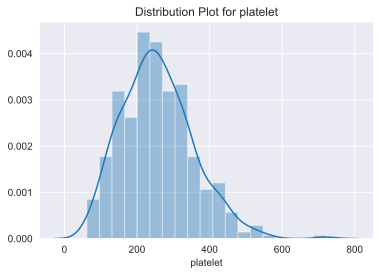

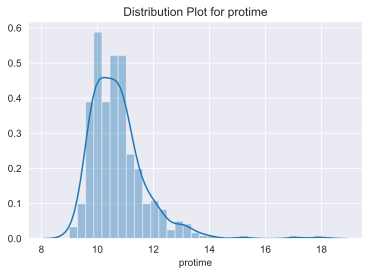

In [9]:
cont_columns = ['age','bili','chol','albumin','copper','alk.phos',
               'ast','trig','platelet','protime']

for col in cont_columns:
    sns.distplot(df[col])
    plt.title(f"Distribution Plot for {col}")
    plt.show()

### Data Preparation

In [10]:
df = pd.read_csv('data/pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'].apply(lambda x: 1 if x==2.0 else 0)
df['time'] = df['time'].apply(lambda x: x / 365.0)
df['trt'] = df['trt'].apply(lambda x: 1 if x==2 else 0)
df['sex'] = df['sex'].apply(lambda x: 0 if x=='f' else 1)

df = df.drop(['id'], axis=1)
df = df.dropna(axis=0)

In [11]:
df.shape

(258, 19)

#### Dummy Encode Categorical Variables

In [12]:
onehot_df = pd.get_dummies(df, columns=['edema','stage'], drop_first=True)

#### Split data into training-validation-testing sets

In [13]:
np.random.seed(0)
df_dev, df_test = train_test_split(onehot_df, test_size = 0.25)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

#### Normalization of Continuous Features
* Use the training set mean and standard deviation to normalize the features in the validation and testing splits

In [14]:
cont_columns = ['age', 'bili', 'chol', 'albumin', 'copper','alk.phos',
               'ast','trig','platelet','protime']

train_mean = df_train.loc[:, cont_columns].mean()
train_std = df_train.loc[:, cont_columns].std()

df_train.loc[:, cont_columns] = (df_train.loc[:, cont_columns] - train_mean) / train_std
df_val.loc[:, cont_columns] = (df_val.loc[:, cont_columns] - train_mean) / train_std
df_test.loc[:, cont_columns] = (df_test.loc[:, cont_columns] - train_mean) / train_std

### Kaplan-Meier Survival Estimates
The **Kaplan-Meier Product-Limit Method** is a non-parametric technique used for estimating the survival function. The idea is that if we have survival times for $n$ individuals and $r$ of these survival times are larger than a specified time $t$, then the probability of surviving more than $t$ units of time would simply be ${\dfrac{r}{n}}$.

$$
S(t)=P(T>t)= {\dfrac{r}{n}}
$$


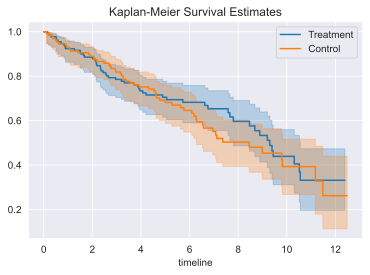

In [15]:
from lifelines import KaplanMeierFitter

trt = df['trt'] == 1

kmf = KaplanMeierFitter()
kmf.fit(df[trt]['time'], df[trt]['status'], label='Treatment')
kmf.plot()

kmf.fit(df[~trt]['time'], df[~trt]['status'], label='Control')
kmf.plot()
plt.title('Kaplan-Meier Survival Estimates')
plt.show()

### Log-Rank Test for Comparison Between Groups
The Log-Rank test is a statistical method that can be used to detect the differences between survival curves of two different groups, typically treatment versus control groups. 

The mortality rate can be described in the hazard function $h(t)$ conditioned on the survival until time $t$ where compare the hazard functions of both groups by computing a **hazard ratio**. 

$$
h(T)= {\dfrac{-S'(t)}{S(t)}}
$$

A constant hazard ratio of Ψ units means that if an individual survived for $t$ units, the chance of experiencing the event follow $t$ is Ψ times greater in one group pthan in the other group, and the same for all values of $t$. 

The null hypothesis for the log-rank test is:

$$
H_0: Ψ = 1
$$

stating that there is no difference in survival experience between the two groups.

The idea is that it is a chi-squared test that compares the observed and expected number of deaths in each time interval of the study. One major assumption is the **proportional hazards assumption** in that the ratio of the two mortality rates of each group are constant over time. 

$$
χ^2= {\dfrac{(O_1 - E_1 )^2}{E_1}} + {\dfrac{(O_2 - E_2 )^2}{E_2}}
$$

A significant log-rank test statistic $(p<0.05)$ suggests that there the difference in the survivability between the two groups is statistically significant, and that we have enough evidence to reject $H_0$. 

In [16]:
#Number of patients experiencing infections in the control group
df[~trt]['status'].sum()

57

In [17]:
#Number of patients experiencing infections in the treatment group
df[trt]['status'].sum()

54

In [18]:
from lifelines.statistics import logrank_test

results = logrank_test(df[trt]['time'], df[~trt]['time'], 
                       df[trt]['status'], df[~trt]['status'])

results.print_summary()

The test statistic of 0.33 with the corresponding p-value of 0.56 suggests that the difference in survivability between the treatment and control group are not statistically significant. This means we do not have enough evidence to the reject the null hypothesis for this statistical test. 

### Cox Proportional Hazards Model (Cox Regression)
The Cox PH model is a semi-parametric regression model used to model survival data when several covariates of interests are being investigated for their effect on survivability.

$$
h(t) = h_0(t) * e^{β_1X_1 + β_2X_2 + ... + β_kX_k}
$$

* $h_0(t)$ represents the baseline hazard where all covariates equal 0
* $h(t)$ represents the hazard function

#### Performance Metric

I will be using the **Harrell's Concordance Index (c-index)** to evaluate model performances. The c-index is a concordant statistic where the idea is that a patient with a shorter time to event (eg. faster time to death) should have a higher risk score than a patient with a longer time to event (eg. slower time to death).

### Full CPH Model
* Using all covariates

In [19]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col= 'time', event_col='status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>

In [20]:
cph.check_assumptions(df_train)

Proportional hazard assumption looks okay.


In [21]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 62
   partial log-likelihood = -214.48
         time fit was run = 2020-12-03 19:35:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt        -0.14       0.87       0.32            -0.77             0.49                 0.46                 1.63
age         0.19       1.20       0.20            -0.21             0.58                 0.81                 1.79
sex         0.65       1.92       0.41            -0.15             1.46                 0.86                 4.29
ascites     2.00       7.39       0.77             0.49             3.51                 1.63                33.57
hepato      0.72       2.05       0.35             0.03             1.40                 1.03                 4.06
spiders     0.46       1.59       0.39            -0.30             1.23                 0.74                 3.43
bili        0.40       1.49       0.17             0.06             0.74                 1.06                 2.10
chol        0.28       1.32       0.16            -0.03             0.59                 0.97                 1.80
albumin    -0.36       0.70       0.18            -0.71            -0.01                 0.49                 0.99
copper      0.43       1.54       0.16             0.11             0.75                 1.12                 2.12
alk.phos   -0.18       0.83       0.16            -0.49             0.13                 0.61                 1.14
ast         0.06       1.06       0.17            -0.28             0.39                 0.76                 1.48
trig       -0.09       0.91       0.16            -0.40             0.22                 0.67                 1.24
platelet   -0.16       0.85       0.17            -0.50             0.17                 0.61                 1.19
protime    -0.00       1.00       0.19            -0.38             0.38                 0.68                 1.46
edema_0.5   0.45       1.56       0.47            -0.47             1.36                 0.62                 3.91
edema_1.0   0.22       1.25       0.71            -1.17             1.61                 0.31                 5.02
stage_2.0   0.67       1.96       1.11            -1.50             2.84                 0.22                17.08
stage_3.0   1.06       2.90       1.06            -1.02             3.15                 0.36                23.31
stage_4.0   0.80       2.22       1.13            -1.43             3.02                 0.24                20.49
              z    p   -log2(p)
covariate                      
trt       -0.43 0.67       0.58
age        0.92 0.36       1.49
sex        1.59 0.11       3.17
ascites    2.59 0.01       6.70
hepato     2.05 0.04       4.62
spiders    1.18 0.24       2.08
bili       2.31 0.02       5.57
chol       1.76 0.08       3.69
albumin   -2.01 0.04       4.51
copper     2.63 0.01       6.89
alk.phos  -1.16 0.25       2.01
ast        0.34 0.74       0.44
trig      -0.58 0.56       0.83
platelet  -0.95 0.34       1.55
protime   -0.02 0.98       0.02
edema_0.5  0.95 0.34       1.55
edema_1.0  0.31 0.76       0.40
stage_2.0  0.61 0.54       0.88
stage_3.0  1.00 0.32       1.66
stage_4.0  0.70 0.48       1.05
---
Concordance = 0.84
Partial AIC = 468.96
log-likelihood ratio test = 99.20 on 20 df
-log2(p) of ll-ratio test = 39.06

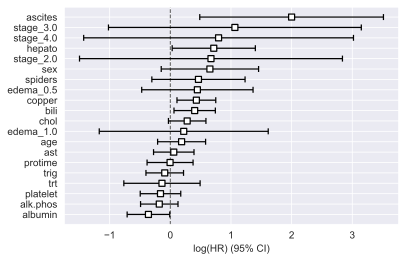

In [68]:
cph.plot()
plt.show()

In [22]:
print("Full CPH Model")
print("Training Score: ",cph.score(df_train, scoring_method="concordance_index"))
print("Validation Score: ", cph.score(df_val, scoring_method="concordance_index"))
print("Testing Score: ",cph.score(df_test, scoring_method="concordance_index"))

Full CPH Model
Training Score:  0.8387952263686305
Validation Score:  0.8061068702290076
Testing Score:  0.8607594936708861


### Mayo Clinic CPH Model

Replicated from research paper by E. Rolland Dickson, Patricia M. Grambsch, Thomas R. Fleming, Lloyd D. Fisher, and Alice Langworthy.

Paper: http://hbiostat.org/papers/rms/datasetsCaseStudies/dic89pro.pdf

In [23]:
df = pd.read_csv('data/pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'].apply(lambda x: 1 if x==2.0 else 0)
df['time'] = df['time'].apply(lambda x: x / 365.0)
df['trt'] = df['trt'].apply(lambda x: 1 if x==2 else 0)
df['sex'] = df['sex'].apply(lambda x: 0 if x=='f' else 1)

df['bili'] = df['bili'].apply(lambda x: np.log(x))
df['copper'] = df['copper'].apply(lambda x: np.log(x))
df['protime'] = df['protime'].apply(lambda x: np.log(x))

df = df.drop(['id'], axis=1)
df = df.dropna(axis=0)

mayo = df.copy()
columns = ['time','status','age','bili','protime','edema','albumin']
mayo = mayo[columns]

np.random.seed(0)
mayo_dev, mayo_test = train_test_split(mayo, test_size = 0.25)
mayo_train, mayo_val = train_test_split(mayo_dev, test_size = 0.25)

In [24]:
mayo_cph = CoxPHFitter()
mayo_cph.fit(mayo_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>

In [25]:
mayo_cph.check_assumptions(mayo_train)

Proportional hazard assumption looks okay.


In [26]:
mayo_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 62
   partial log-likelihood = -228.39
         time fit was run = 2020-12-03 19:35:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
bili        0.79       2.21       0.14             0.52             1.06                 1.69                 2.89
protime     1.86       6.43       1.37            -0.83             4.55                 0.44                94.73
edema       0.72       2.06       0.47            -0.21             1.65                 0.81                 5.22
albumin    -0.86       0.42       0.34            -1.52            -0.21                 0.22                 0.81
              z      p   -log2(p)
covariate                        
age        1.57   0.12       3.11
bili       5.78 <0.005      26.99
protime    1.36   0.17       2.52
edema      1.53   0.13       2.98
albumin   -2.57   0.01       6.63
---
Concordance = 0.80
Partial AIC = 466.78
log-likelihood ratio test = 71.37 on 5 df
-log2(p) of ll-ratio test = 44.10

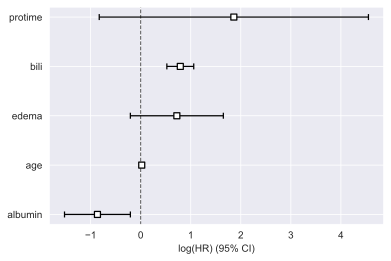

In [69]:
mayo_cph.plot()
plt.show()

In [27]:
print("Mayo Clinic Model")
print("Training Score: ",mayo_cph.score(mayo_train, scoring_method="concordance_index"))
print("Validation Score: ", mayo_cph.score(mayo_val, scoring_method="concordance_index"))
print("Testing Score: ",mayo_cph.score(mayo_test, scoring_method="concordance_index"))

Mayo Clinic Model
Training Score:  0.8010986929342678
Validation Score:  0.8534351145038168
Testing Score:  0.8742088607594937


### Random Survival Forests

Introducing machine learning methods to survival analysis has helped solve some issues with traditional survival models. Survival trees is advantageous in that it can model non-linear relationships. Cox Proportional Hazards model assumes the shape of the risk is the same in all patients, different only in the proportions. On the other hand, survival trees captures the non-linearities between patients where risk factor hazards can change and switch over time.

Paper: https://arxiv.org/pdf/0811.1645.pdf

In [28]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.util import Surv

In [29]:
df = pd.read_csv('data/pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'].apply(lambda x: 1 if x==2.0 else 0)
df['time'] = df['time'].apply(lambda x: x / 365.0)
df['trt'] = df['trt'].apply(lambda x: 1 if x==2 else 0)
df['sex'] = df['sex'].apply(lambda x: 0 if x=='f' else 1)

df['bili'] = df['bili'].apply(lambda x: np.log(x))
df['chol'] = df['chol'].apply(lambda x: np.log(x))
df['copper'] = df['copper'].apply(lambda x: np.log(x))
df['albumin'] = df['albumin'].apply(lambda x: np.log(x))
df['protime'] = df['protime'].apply(lambda x: np.log(x))

df = df.drop(['id'], axis=1)
df = df.dropna(axis=0)

np.random.seed(0)
rf_df_dev, rf_df_test = train_test_split(df, test_size = 0.25)
rf_df_train, rf_df_val = train_test_split(rf_df_dev, test_size = 0.25)

In [30]:
X_train = rf_df_train.drop(['time','status'], axis=1)
y_train = Surv.from_arrays(rf_df_train['status'], rf_df_train['time'])

X_val = rf_df_val.drop(['time','status'], axis=1)
y_val = Surv.from_arrays(rf_df_val['status'], rf_df_val['time'])

X_test = rf_df_test.drop(['time','status'], axis=1)
y_test = Surv.from_arrays(rf_df_test['status'], rf_df_test['time'])

In [31]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num =20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 20, num=10)]
min_samples_split = [2,3,5,7,9,11]
min_samples_leaf = [2,3,4,5,6,7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

rsf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(estimator = rsf, 
                               param_distributions = random_grid,
                               n_iter=100,
                               verbose=2, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished


RandomizedSearchCV(estimator=RandomSurvivalForest(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 5, 7, 9,
                                                              11],
                                        'n_estimators': [100, 147, 194, 242,
                                                         289, 336, 384, 431,
                                                         478, 526, 573, 621,
                                                         668, 715, 763, 810,
                                                         857, 905, 952, 1000]},
                   verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 857,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 10}

In [33]:
rsf = RandomSurvivalForest(**rf_random.best_params_)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                     n_estimators=857)

In [34]:
print("Random Survival Forest Model")
print("Training Score: ", rsf.score(X_train, y_train))
print("Validation Score: ", rsf.score(X_val, y_val))
print("Testing Score: ", rsf.score(X_test, y_test))

Random Survival Forest Model
Training Score:  0.9047168024247016
Validation Score:  0.8259541984732824
Testing Score:  0.877373417721519


In [35]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0465 ± 0.0396,bili
0.0422 ± 0.0286,copper
0.0193 ± 0.0167,albumin
0.0147 ± 0.0176,ascites
0.0138 ± 0.0143,protime
0.0095 ± 0.0077,age
0.0056 ± 0.0118,chol
0.0034 ± 0.0031,ast
0.0033 ± 0.0074,stage
0.0033 ± 0.0041,spiders


* The permutation importance suggests bili has the most impact on the positive outcome for the disease which makes sense because pbc is the result of bile buildup in the liver. It is great that the survival forest picked this out.
* Furthermore, it looks like the treatment has a small but negative effect which shows promise that the treatment can help.

### Survival Support Vector Machine

In [36]:
df = pd.read_csv('data/pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'].apply(lambda x: 1 if x==2.0 else 0)
df['time'] = df['time'].apply(lambda x: x / 365.0)
df['trt'] = df['trt'].apply(lambda x: 1 if x==2 else 0)
df['sex'] = df['sex'].apply(lambda x: 0 if x=='f' else 1)

df['bili'] = df['bili'].apply(lambda x: np.log(x))
df['copper'] = df['copper'].apply(lambda x: np.log(x))
df['protime'] = df['protime'].apply(lambda x: np.log(x))

df = df.drop(['id'], axis=1)
df = df.dropna(axis=0)

svm_onehot_df = pd.get_dummies(df, columns=['edema','stage'], drop_first=False)

np.random.seed(0)
svm_df_dev, svm_df_test = train_test_split(svm_onehot_df, test_size = 0.25)
svm_df_train, svm_df_val = train_test_split(svm_df_dev, test_size = 0.25)

In [37]:
cont_columns = ['age', 'bili', 'chol', 'albumin', 'copper','alk.phos',
               'ast','trig','platelet','protime']

train_mean = df_train.loc[:, cont_columns].mean()
train_std = df_train.loc[:, cont_columns].std()

svm_df_train.loc[:, cont_columns] = (svm_df_train.loc[:, cont_columns] - train_mean) / train_std
svm_df_val.loc[:, cont_columns] = (svm_df_val.loc[:, cont_columns] - train_mean) / train_std
svm_df_test.loc[:, cont_columns] = (svm_df_test.loc[:, cont_columns] - train_mean) / train_std

In [38]:
svm_X_train = svm_df_train.drop(['time','status'], axis=1)
svm_y_train = Surv.from_arrays(svm_df_train['status'], svm_df_train['time'])

svm_X_val = svm_df_val.drop(['time','status'], axis=1)
svm_y_val = Surv.from_arrays(svm_df_val['status'], svm_df_val['time'])

svm_X_test = svm_df_test.drop(['time','status'], axis=1)
svm_y_test = Surv.from_arrays(svm_df_test['status'], svm_df_test['time'])

In [39]:
random_grid = {'optimizer': ['rbtree','simple','avltree'],
               'fit_intercept': [True,False],
               'max_iter': [int(x) for x in np.linspace(start=20, stop =60, num =20)],
               'alpha': [1,2,3,4,5,6,7,8,9,10],
               'tol':[1e-5,1e-6, 1e-7]
              }

fastsvm = FastSurvivalSVM()

fastsvm_random = RandomizedSearchCV(estimator = fastsvm, 
                               param_distributions = random_grid,
                               n_iter=100,
                               verbose=2, 
                               n_jobs = -1)

fastsvm_random.fit(svm_X_train, svm_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished


RandomizedSearchCV(estimator=FastSurvivalSVM(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10],
                                        'fit_intercept': [True, False],
                                        'max_iter': [20, 22, 24, 26, 28, 30, 32,
                                                     34, 36, 38, 41, 43, 45, 47,
                                                     49, 51, 53, 55, 57, 60],
                                        'optimizer': ['rbtree', 'simple',
                                                      'avltree'],
                                        'tol': [1e-05, 1e-06, 1e-07]},
                   verbose=2)

In [40]:
fastsvm_random.best_params_

{'tol': 1e-07,
 'optimizer': 'simple',
 'max_iter': 22,
 'fit_intercept': False,
 'alpha': 6}

In [41]:
print("Fast Survival SVM Model")
print("Training Score: ", fastsvm_random.score(svm_X_train, svm_y_train))
print("Validation Score: ", fastsvm_random.score(svm_X_val, svm_y_val))
print("Testing Score: ", fastsvm_random.score(svm_X_test, svm_y_test))

Fast Survival SVM Model
Training Score:  0.8386057965523773
Validation Score:  0.8290076335877863
Testing Score:  0.8560126582278481


### Model Comparisons

In [42]:
print("Full CPH Model")
print("Training Score: ",cph.score(df_train, scoring_method="concordance_index"))
print("Validation Score: ", cph.score(df_val, scoring_method="concordance_index"))
print("Testing Score: ",cph.score(df_test, scoring_method="concordance_index"))
print("=========================================")
print("Mayo Clinic Model")
print("Training Score: ",mayo_cph.score(mayo_train, scoring_method="concordance_index"))
print("Validation Score: ", mayo_cph.score(mayo_val, scoring_method="concordance_index"))
print("Testing Score: ",mayo_cph.score(mayo_test, scoring_method="concordance_index"))
print("=========================================")
print("Random Survival Forest Model")
print("Training Score: ", rsf.score(X_train, y_train))
print("Validation Score: ", rsf.score(X_val, y_val))
print("Testing Score: ", rsf.score(X_test, y_test))
print("=========================================")
print("Fast Survival SVM Model")
print("Training Score: ", fastsvm_random.score(svm_X_train, svm_y_train))
print("Validation Score: ", fastsvm_random.score(svm_X_val, svm_y_val))
print("Testing Score: ", fastsvm_random.score(svm_X_test, svm_y_test))

Full CPH Model
Training Score:  0.8387952263686305
Validation Score:  0.8061068702290076
Testing Score:  0.8607594936708861
Mayo Clinic Model
Training Score:  0.8010986929342678
Validation Score:  0.8534351145038168
Testing Score:  0.8742088607594937
Random Survival Forest Model
Training Score:  0.9047168024247016
Validation Score:  0.8259541984732824
Testing Score:  0.877373417721519
Fast Survival SVM Model
Training Score:  0.8386057965523773
Validation Score:  0.8290076335877863
Testing Score:  0.8560126582278481


### Conclusion

* The random survival forest model performs roughly the same as the Mayo Clinic CPH model on the testing set. 
* The Mayo Clinic model is simpler and easier to train, however, we did have to make judgements on selecting the correct input features and choosing whether to perform log transformations or not on them. 
* The random survival forest did take a little longer to train as it was searching for the best hyperparameters through the grid search. An advantage over the Mayo Clinic model is that you can simply pass all of the raw features into the model without the need of data pre-processing and we still get the same performance.
* The full feature CPH model and the fast survival SVM performed slightly poorer than the above models. This makes sense because the full cph model is more of a naive approach since we are just using all of the features.
* With these survival models, we can make a judgement on the risk an individual patient with pbc at a given time

### Predicting Survival Curves for New Observations (Patients)
Using our survival models, we can produce survival curves for patients given their covariates. This is useful for clinicians to diagnose the severity of a patient's condition with a particular disease. Using the survival models to predict the survival probabilities, clinicians can strategize a treatment plan for patients.

Survival probabilities over time: 
 [1.         0.99980552 0.99870534 0.99870534 0.99762599 0.99483108
 0.99483108 0.99185512 0.99185512 0.98906299 0.98859625 0.98759654
 0.98745069 0.98745069 0.98595183 0.98143626 0.97643681 0.97566122
 0.97405077 0.97268063 0.97268063 0.96629438 0.96216569 0.95814557
 0.95814557 0.95765938 0.9324852  0.93185546 0.93153944 0.917219
 0.90922276 0.89861065 0.89670038 0.8963017  0.89507742 0.89458689
 0.88762998 0.86058018 0.84416224 0.82479046 0.82132414 0.82104631
 0.82104631 0.82049935 0.81696805 0.79794597 0.79742737 0.78763443
 0.75695802 0.74024588 0.72123655 0.66526742 0.6626399  0.65747104
 0.62279895 0.61707176 0.61580766 0.59750873 0.56168497 0.53588116
 0.51311691 0.46609281]


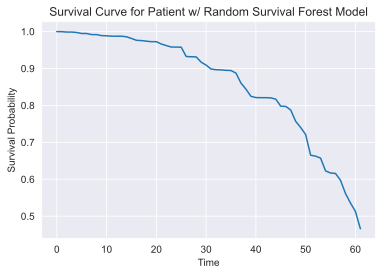

In [94]:
observation = X_test.sample(5)
prediction = rsf.predict_survival_function(observation)[0]
print('Survival probabilities over time: \n', prediction)
plt.plot(np.arange(len(prediction)), prediction)
plt.title('Survival Curve for Patient w/ Random Survival Forest Model')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()